# Task 3: Neuronal Activity & Place Cells
Last time we calculated the animal's speed from its position data, an important behavioral metric.

This time, we will use both the behavioral data (position & speed) and neuronal activity data (calcium imaging) to explore how neurons in the hippocampus encode spatial information.

We will correlate animal behavior (Run vs Rest) with neuronal activity (Calcium imaging).
And we will map neuronal events to spatial locations to find Place Cells.

### Loading Speed Data
First, we load the speed data from Task 3 and look at the animal's running behavior.

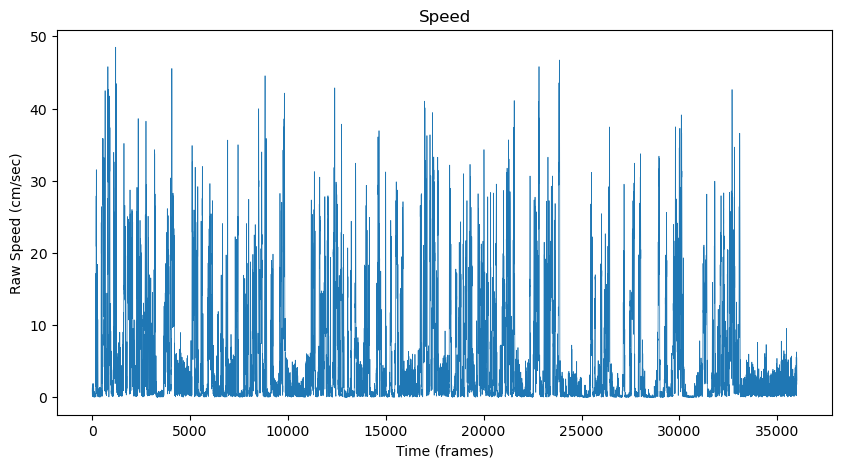

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Load 'speed.csv' using pd.read_csv()
speed_df = ...
cm_per_sec = speed_df['cm/sec'].values  # Extract speed as a 1D array

##### Plotting raw speed
plt.figure(figsize=(10, 5))
plt.plot(cm_per_sec, linewidth=0.5)
plt.xlabel('Time (frames)')
plt.ylabel('Raw Speed (cm/sec)')
plt.title('Speed')
plt.show()

## 1. Binarize Behavior (Run vs Rest)
In this task we want to use our knowledge of the animals speed, to sort the experiments in times of running and in times of resting behavior. 
- We can do this by thresholding the animals lower bound running speed. 
- In addition to that we create a logical or boolen vector, that gets us a 1 for each frame the animal is running and a 0 for each frame the animal is at rest. 
- With this logical vector we can then sort our neuronal data to look at the differences between running and resting neuronal activity

### 1.1 Smooth the speed data first

We can already see periods of running and resting in the raw speed plot, but the data looks jumpy and noisy — just like the position data before. So let's smooth it again!

We will use the `pd.Series.rolling().mean()` function to smooth the speed data.

**Your Task:** Look back at Task 2 to see how we used the rolling mean, and apply the same technique to the speed data.

**Question 3.1:** 
How do you choose the `k` value for smoothing the speed? What biological and computational aspects should you consider? Did the result match your expectations? If not, explain why and how you adjusted `k`.

In [ ]:
# TODO: Choose a smoothing window size k
k = ...

# TODO: Smooth the speed using pd.Series().rolling(window=k, center=True).mean()
# Use .fillna(0).values at the end to handle edge NaN values
smooth_speed = ...

### 1.2 Binarize the behavior — threshold the speed
Now we threshold the speed to create a binary (logical) vector of running vs. resting behavior.

To do this, choose a lower-bound running speed. Look at the speed plot and pick a value that separates running from resting periods. The `>=` operator creates a boolean vector that is `True` (1) when the animal is running and `False` (0) when it is resting.

**Question 3.3**: 

1. Find a good lower-bound threshold for the running speed. Think about what "running" means biologically and how tracking noise might affect the measured speed.
2. What ratio of running vs. resting frames do you get with your threshold? Is this what you expected? If not, explain why.

Percentage of time running: 34.78%


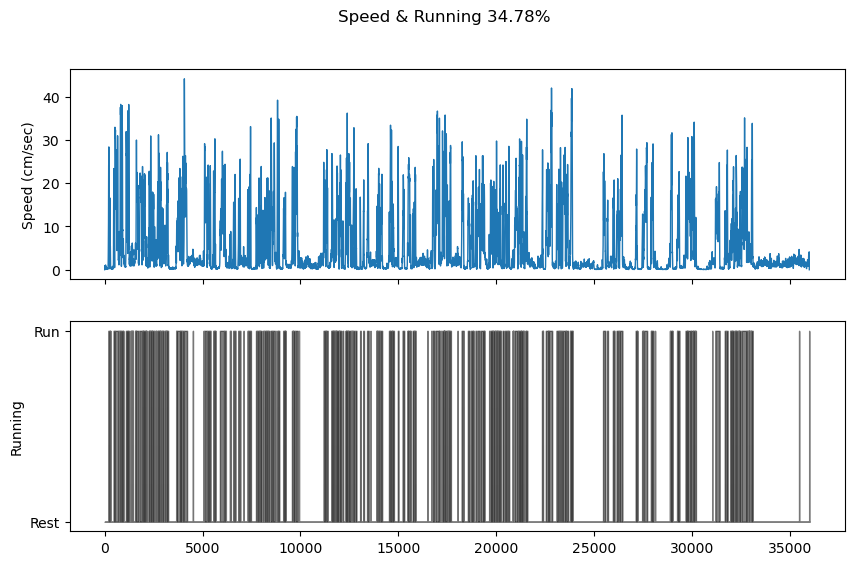

In [ ]:
# TODO: Choose a lower-bound threshold for running speed (in cm/sec)
low_bound_cm_per_sec = ...

# TODO: Create boolean vectors for running and resting
# Hint: use >= for running, < for resting
is_running = ...
is_resting = ...

# TODO: Calculate the percentage of time the animal spends running
percentage_running = ...
print(f'Percentage of time running: {percentage_running:.2f}%')

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax1.plot(smooth_speed, linewidth=1)
fig.suptitle(f'Speed & Running {percentage_running:.2f}%')
ax1.set_ylabel('Speed (cm/sec)')
ax2.fill_between(range(len(is_running)), is_running, color='k', alpha=0.5)
ax2.set_ylabel('Running')
ax2.set_yticks([0, 1], ['Rest', 'Run'])
plt.show()

**Question 3.4**: 

Did your considerations turned out as expected? If not, explain why and how you changed the k-value!

In [ ]:
# Answer

## 2. Neuronal Activity
Now we finally get to look at the neuronal activity data! The data has been preprocessed: neuronal calcium signals have been deconvolved and binarized, so each time point is either a spike event (`1`) or no event (`0`).

- Load `binarized_traces.csv`, which contains binary events for each detected neuron.
- Visualize the neuronal activity as a **Raster Plot** alongside the animal's behavior.

**Question 3.7:**

What patterns can you observe in the raster plot? Do you notice anything that fits your knowledge about neuronal activity? Where do the events have the highest frequency — during running or resting?

Neuronal Data Shape (Frames x Cells): (36025, 365)


C:\Users\mauls\AppData\Local\Temp\ipykernel_4540\1508508808.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


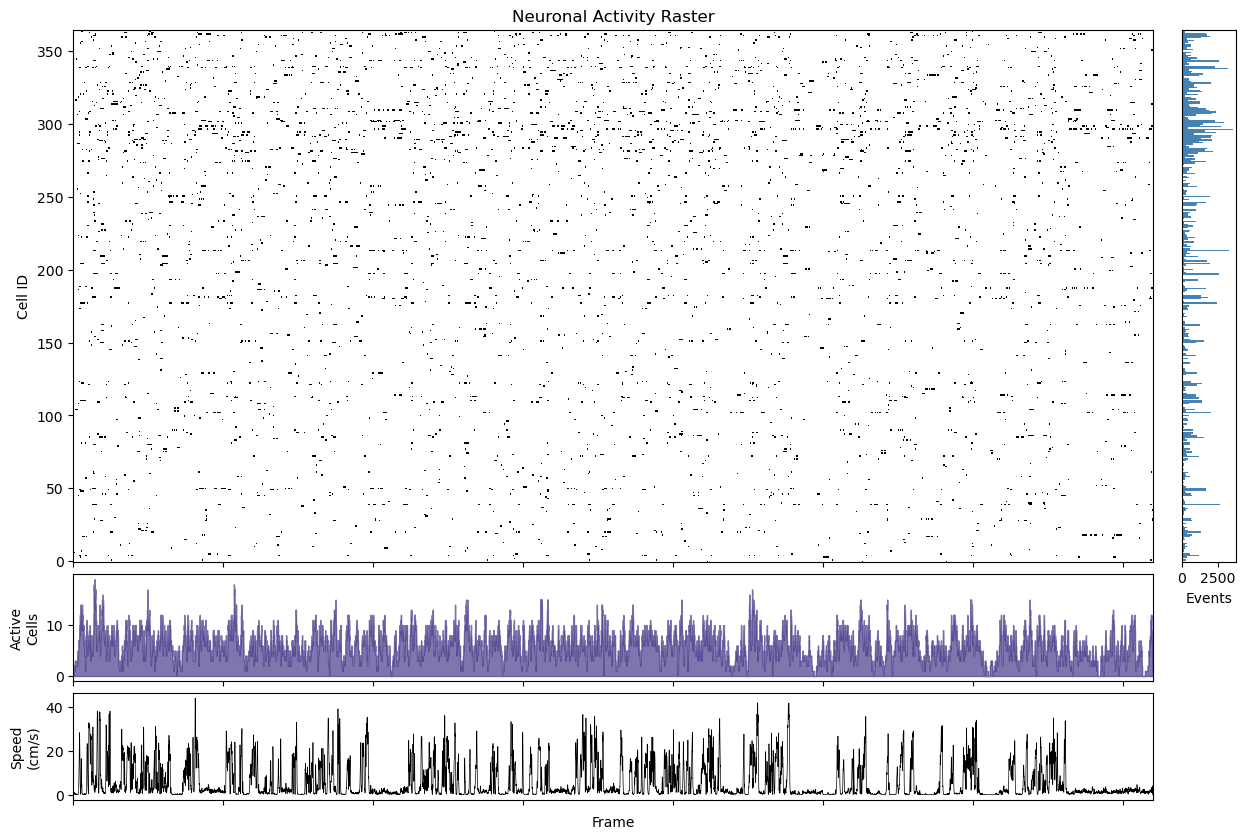

In [ ]:
# TODO: Load 'binarized_traces.csv' using pd.read_csv()
traces_df = ...
F_upphase = traces_df.values  # Convert to numpy array (Frames x Cells)

print("Neuronal Data Shape (Frames x Cells):", F_upphase.shape)

############# Visualize Raster Plot with additional statistics
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 2, figure=fig, width_ratios=[20, 1], height_ratios=[10, 2, 2], 
              hspace=0.05, wspace=0.05)

# Top left: Raster plot
ax_raster = fig.add_subplot(gs[0, 0])
ax_raster.imshow(F_upphase.T, aspect='auto', cmap='gray_r', interpolation='none')
ax_raster.set_ylabel('Cell ID')
ax_raster.set_title('Neuronal Activity Raster')
ax_raster.set_xticklabels([])

# Top right: Firing rate per neuron (vertical histogram)
ax_fire_rate = fig.add_subplot(gs[0, 1], sharey=ax_raster)
firing_rate_per_neuron = np.sum(F_upphase, axis=0)  # Sum over time for each neuron
ax_fire_rate.barh(range(F_upphase.shape[1]), firing_rate_per_neuron, height=1, color='steelblue')
ax_fire_rate.set_xlabel('Events')
ax_fire_rate.set_ylim(ax_raster.get_ylim())
ax_fire_rate.invert_yaxis()
ax_fire_rate.yaxis.set_visible(False)

# Bottom left: Activity per frame (horizontal histogram)
ax_activity = fig.add_subplot(gs[1, 0], sharex=ax_raster)
activity_per_frame = np.sum(F_upphase, axis=1)  # Sum over neurons for each frame
ax_activity.fill_between(range(len(activity_per_frame)), activity_per_frame, color='darkslateblue', alpha=0.7)
ax_activity.set_ylabel('Active\nCells')
ax_activity.set_xlim(ax_raster.get_xlim())
ax_activity.set_xticklabels([])

# Bottom: Speed plot
ax_speed = fig.add_subplot(gs[2, 0], sharex=ax_raster)
ax_speed.plot(smooth_speed, linewidth=0.5, color='black')
ax_speed.set_ylabel('Speed\n(cm/s)')
ax_speed.set_xlabel('Frame')
ax_speed.set_xlim(ax_raster.get_xlim())

plt.tight_layout()
plt.show()

**Question 3.6:** 

Look at the variable and derive by the matrix size, how many cells were detected in this set?

In [ ]:
# Answer for Question 3.6: How many cells were detected?
F_upphase.shape

(36025, 365)

### Calculate the network event rate
**Question 3.8:**

Calculate the event rate across the entire neuronal network. To do this:
1. Sum all events per frame (across all neurons).
2. Smooth the resulting event rate using a rolling mean.

Try to write this code on your own! Use the Python documentation, Google, and your knowledge from previous tasks.

*Hint: The result should look similar to the speed plot — a time series with peaks and valleys.*

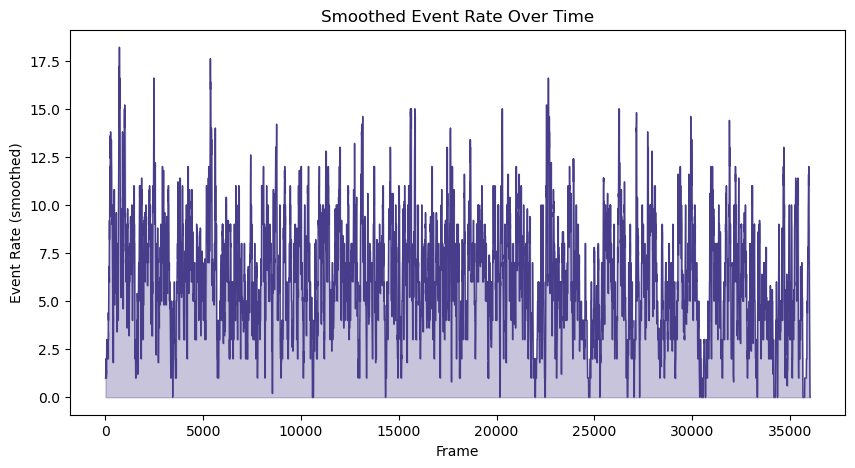

In [ ]:
# TODO: Calculate the event rate (sum of all neuron events per frame)
event_rate = ...

# TODO: Smooth the event rate using a rolling mean
event_rate_smooth = ...

###### Plot smoothed event rate
plt.figure(figsize=(10, 5))
plt.plot(event_rate_smooth, color='darkslateblue', linewidth=1)
plt.fill_between(range(len(event_rate_smooth)), event_rate_smooth, color='darkslateblue', alpha=0.3)
plt.xlabel('Frame')
plt.ylabel('Event Rate (smoothed)')
plt.title('Smoothed Event Rate Over Time')
plt.show()

## 3. Place Cells
Now for the most exciting part — discovering **Place Cells**!

We can use the binarized event data as a logical index to find the spatial coordinates where a specific neuron was active.

**Our goal:** Map individual neurons to spatial locations in the arena. Some neurons will fire at specific locations (Place Cells), while others will fire randomly throughout the arena.

First, load `head_neck_smooth.csv` which contains the smoothed X and Y coordinates of the mouse during the experiment.

Data shapes match: 36000 frames


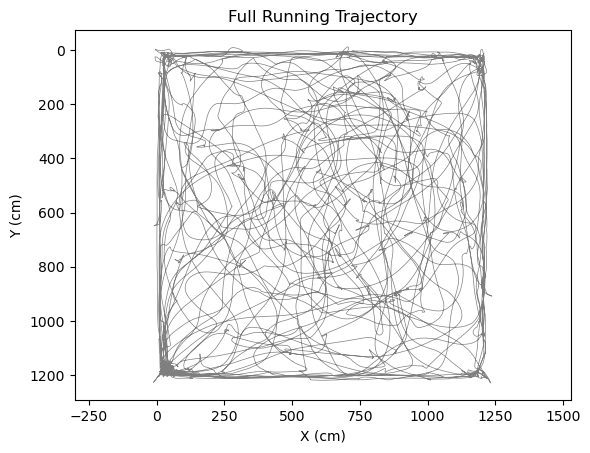

In [ ]:
# TODO: Load 'head_neck_smooth.csv' using pd.read_csv()
coord_df = ...

# TODO: Extract x and y coordinates as numpy arrays
# Hint: coord_df['head_neck_x'].values and coord_df['head_neck_y'].values
x = ...
y = ...

# Check shape alignment between neuronal data and position data
if F_upphase.shape[0] != len(x):
    print(f"Dimensions mismatch: Neuronal {F_upphase.shape}, Position {len(x)}")
    # Truncate to matching length
    min_len = min(F_upphase.shape[0], len(x))
    F_upphase = F_upphase[:min_len, :]
    x = x[:min_len]
    y = y[:min_len]
    print(f"Truncated to matching length: {min_len}")
else:
    print(f"Data shapes match: {F_upphase.shape[0]} frames")

# Plot the full trajectory
plt.figure()
plt.plot(x, y, 'k', alpha=0.5, linewidth=0.5)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title('Full Running Trajectory')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.show()

### 3.1 Extract Activity for a Single Cell

Now we'll pick a specific neuron (Cell ID) and see where it was active in the arena.

The Cell ID corresponds to the column index in our binarized matrix `F_upphase`. Since the microscope recording and the behavioral video are synchronized, each row represents the same time point in both datasets.

**Your Task:**
1. Choose a cell ID (let's start with Cell 123).
2. Extract that cell's binary activity vector from `F_upphase`.
3. Use the activity vector as a boolean index to find the X, Y coordinates where this cell was active.

In [ ]:
# TODO: Choose a cell ID to analyze
cell_id = 123

# TODO: Extract the activity trace for this cell from F_upphase
# Hint: Each column in F_upphase represents one cell
cell_trace = ...

# TODO: Create a boolean vector where the cell is active (cell_trace > 0)
active_frames = ...

# TODO: Use boolean indexing to get only the x,y positions where the cell was active
active_x = ...
active_y = ...

print(f"Cell {cell_id}:")
print(f"  Total frames: {len(cell_trace)}")
print(f"  Active frames: {np.sum(active_frames)}")
print(f"  Firing rate: {np.sum(active_frames)/len(cell_trace)*100:.2f}%")

Cell 123:
  Total frames: 36000
  Active frames: 644
  Firing rate: 1.79%


**Question 3.9**: 

Plot the animal's full running path (in black) and overlay the positions where the neuron was active (as red dots).

Explore different cell IDs and try to identify:
1. **Place Cells** — neurons that fire at specific, localized regions of the arena
2. **Non-Place Cells** — neurons that fire randomly throughout the arena

Write down some interesting cell IDs to compare later!

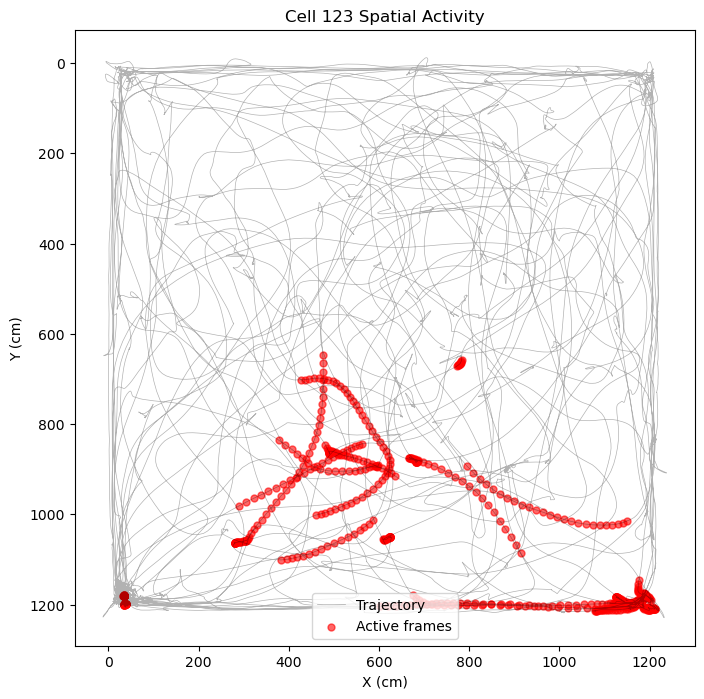

In [ ]:
# TODO: Plot the running path with neuronal activity overlay
# 1. Plot the full trajectory in black (x, y) with low alpha
# 2. Scatter plot the active positions (active_x, active_y) in red
plt.figure(figsize=(8, 8))
# YOUR CODE HERE



plt.gca().invert_yaxis()
plt.axis('equal')
plt.title(f'Cell {cell_id} Spatial Activity')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.legend()
plt.show()

### 3.2 Explore Different Cells

Now try different cell IDs to see the variety of spatial coding patterns. Some cells will show clear place fields (localized activity), while others will be more distributed.

**Try these cell IDs:** 1, 5, 17, 12, 18, 175, 10, 166, 300, 200

Change the `cell_id` variable below and re-run the cells to see different patterns.

Cell 175: 518 active frames (1.44%)


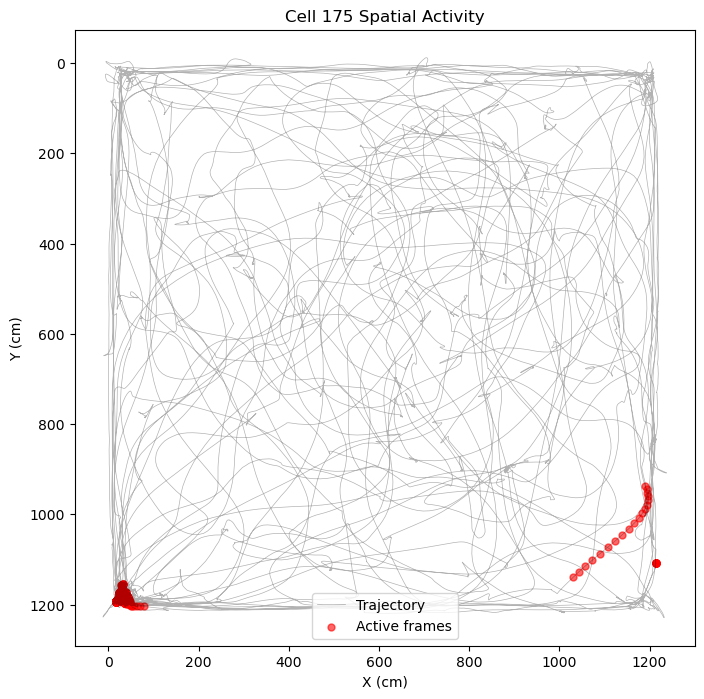

In [ ]:
# TODO: Try different cell IDs here (e.g., 175, 1, 5, 17, etc.)
cell_id = ...

# Extract activity for this cell
cell_trace = F_upphase[:, cell_id]
active_frames = cell_trace > 0
active_x = x[active_frames]
active_y = y[active_frames]

# Plot
plt.figure(figsize=(8, 8))
plt.plot(x, y, 'k', alpha=0.3, linewidth=0.5, label='Trajectory')
plt.scatter(active_x, active_y, c='r', s=25, alpha=0.6, label='Active frames')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title(f'Cell {cell_id} Spatial Activity')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.legend()
print(f"Cell {cell_id}: {np.sum(active_frames)} active frames ({np.sum(active_frames)/len(cell_trace)*100:.2f}%)")
plt.show()

### 3.3 Compare Multiple Place Cells

To better understand the diversity of spatial coding, let's plot multiple cells side-by-side in a grid. This will help you identify:
- **Strong Place Cells**: Fire in very specific, localized regions
- **Weak Place Cells**: Show some spatial preference but less localized
- **Non-Place Cells**: Fire throughout the arena without clear spatial preference

The following code will create a grid showing 16 different cells.

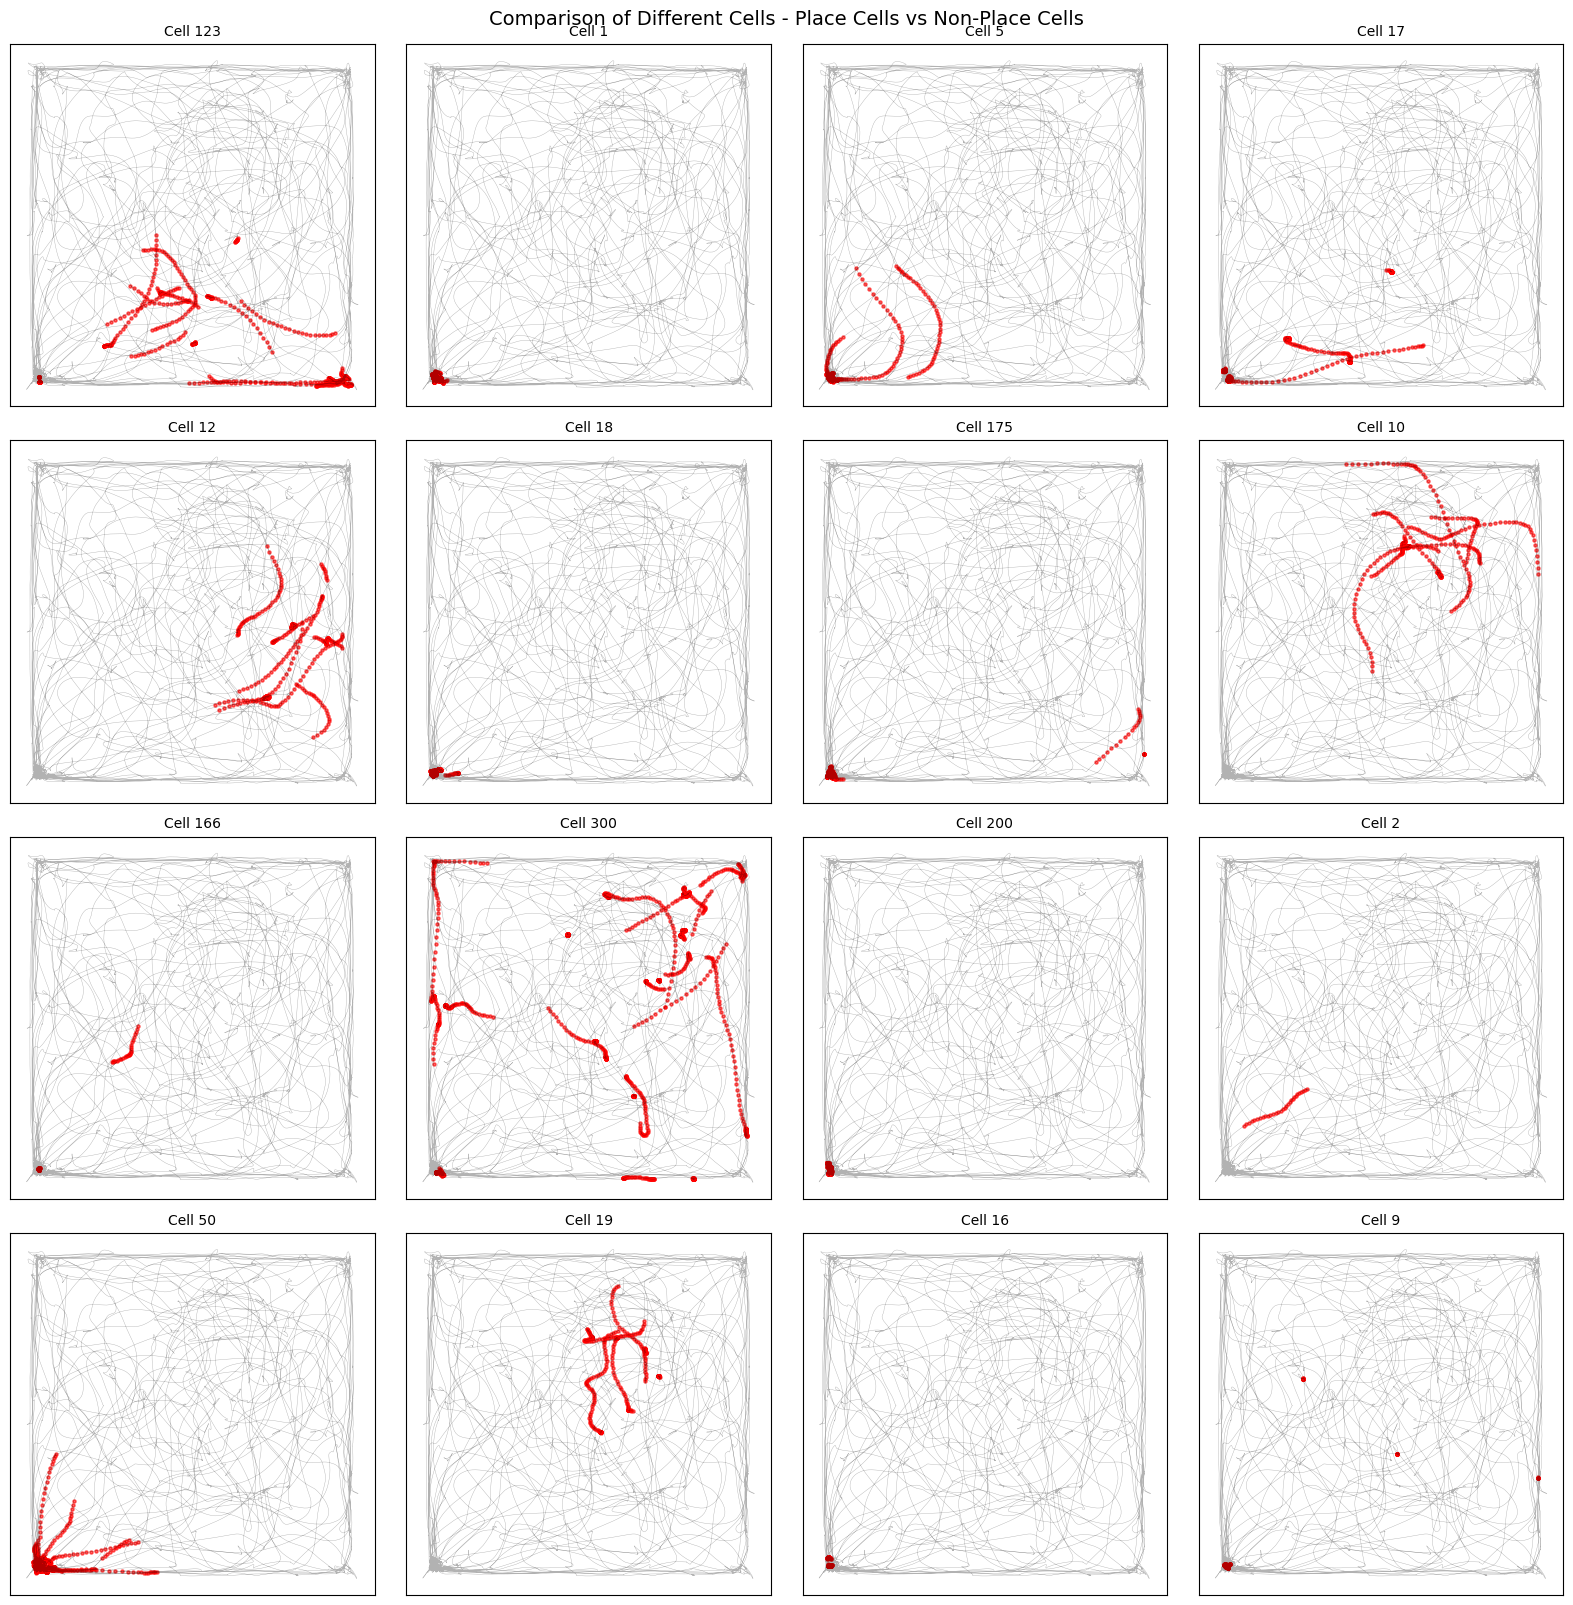

In [ ]:
# TODO: Select interesting cells to compare from your exploration
# Modify this list based on what you found!
cell_ids_to_plot = [...]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

# Plot each cell
for idx, cell_id in enumerate(cell_ids_to_plot):
    # Extract activity for this cell
    cell_trace = F_upphase[:, cell_id]
    active_frames = cell_trace > 0
    active_x = x[active_frames]
    active_y = y[active_frames]
    
    # Plot in subplot
    axes[idx].plot(x, y, 'k', alpha=0.3, linewidth=0.3)
    axes[idx].scatter(active_x, active_y, c='r', s=5, alpha=0.6)
    axes[idx].invert_yaxis()
    axes[idx].set_aspect('equal')
    axes[idx].set_title(f'Cell {cell_id}', fontsize=10)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.tight_layout()
plt.suptitle('Comparison of Different Cells - Place Cells vs Non-Place Cells', 
             fontsize=14, y=1.00)
plt.show()

---

## Congratulations! 🎉

You have successfully discovered **Place Cells** in the hippocampus!

In this task, you learned how to:
1. ✅ Smooth and binarize behavioral data (running vs. resting)
2. ✅ Visualize neuronal activity using raster plots
3. ✅ Calculate network-level event rates
4. ✅ Map individual neuron activity to spatial locations
5. ✅ Identify Place Cells that encode specific locations

**Key Insight:** The hippocampus contains neurons (Place Cells) that fire selectively when the animal is at a specific location in the arena. This spatial coding is fundamental to how the brain creates an internal map of the environment — a discovery that was awarded the **Nobel Prize in Physiology or Medicine in 2014**.

**You have completed all tasks! Well done!** 🎓